# DT2119 project,  2020.05

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import glob
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras import models
from keras import layers
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


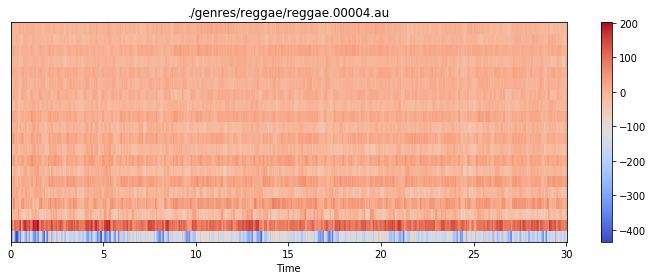

In [7]:
audio_path = './genres/reggae/reggae.00004.au'
y, sr = librosa.load(audio_path)
#mfcc = librosa.feature.mfcc(y)
mfcc = librosa.feature.mfcc(y, n_mfcc=20, hop_length= 512, n_fft=2048)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
#plt.pcolormesh(mfcc)
plt.colorbar()
plt.title(audio_path)
plt.tight_layout()
plt.show()

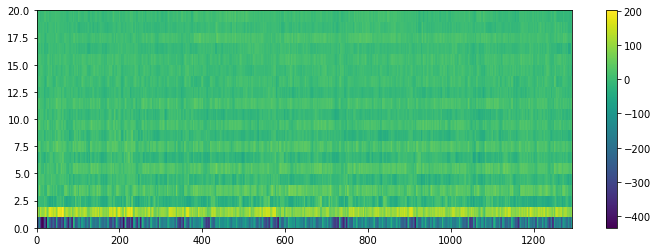

In [8]:
plt.figure(figsize=(12, 4))
plt.pcolormesh(mfcc)
plt.colorbar()

In [9]:
mfcc.shape

(20, 1293)

In [10]:
delta_mfcc = librosa.feature.delta(mfcc)

In [11]:
delta_mfcc.shape

(20, 1293)

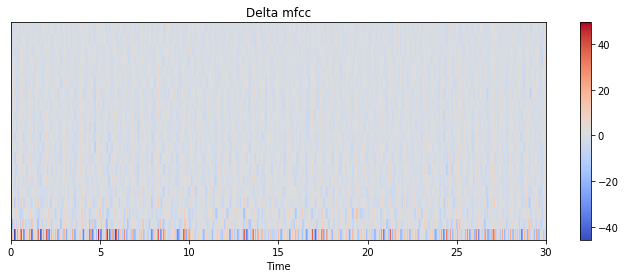

In [12]:
#plt.pcolormesh(delta_mfcc)
plt.figure(figsize=(12, 4))
librosa.display.specshow(delta_mfcc, x_axis='time')
plt.colorbar()
plt.title(delta_mfcc)
plt.title('Delta mfcc')
plt.show()

In [13]:
delta2_mfcc =  librosa.feature.delta(mfcc,order=2)

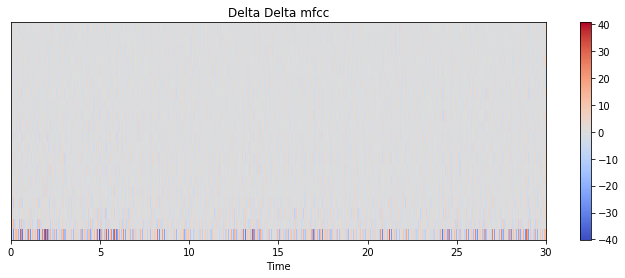

In [14]:
#plt.pcolormesh(delta2_mfcc)
plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc, x_axis='time')
plt.colorbar()
plt.title(delta2_mfcc)
plt.title('Delta Delta mfcc')
plt.show()

In [15]:
3009/30

100.3

In [2]:
def extract_features_song(f,duration=5.0):
    y, sr= librosa.load(f, duration=duration)

    # get Mel-frequency cepstral coefficients
    mfcc = librosa.feature.mfcc(y,n_mfcc=13, hop_length= 512, n_fft=2048)
    # normalize values between -1,1 (divide by max)
    mfcc /= np.amax(np.absolute(mfcc))
    #print(mfcc.shape)
    return np.ndarray.flatten(mfcc)

def generate_features_and_labels():
    all_features = []
    all_labels = []

    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
    #genres = ['blues']
    for genre in genres:
        sound_files = glob.glob('genres/'+genre+'/*.au')
        print('Processing %d songs in %s genre...' % (len(sound_files), genre))
        for f in sound_files:
            features = extract_features_song(f,duration=5.0)
            all_features.append(features)
            all_labels.append(genre)

    # convert labels to one-hot encoding
    label_uniq_ids, label_row_ids = np.unique(all_labels, return_inverse=True)
    label_row_ids = label_row_ids.astype(np.int32, copy=False)
    onehot_labels = to_categorical(label_row_ids, len(label_uniq_ids))
    return np.stack(all_features), onehot_labels

In [3]:
features, labels = generate_features_and_labels()

Processing 0 songs in blues genre...
Processing 0 songs in classical genre...
Processing 0 songs in country genre...
Processing 0 songs in disco genre...
Processing 0 songs in hiphop genre...
Processing 0 songs in jazz genre...
Processing 0 songs in metal genre...
Processing 0 songs in pop genre...
Processing 0 songs in reggae genre...
Processing 0 songs in rock genre...


ValueError: zero-size array to reduction operation maximum which has no identity

In [18]:
features.shape

(1000, 2808)

In [19]:
labels.shape

(1000, 10)

In [20]:
np.savez("./features.npz",features)
np.savez("./labels_one_hot.npz",labels)

In [23]:
y = np.load('labels_one_hot.npz',allow_pickle=True)

In [24]:
y['arr_0'].shape

(1000, 10)

In [25]:
X = np.load('features.npz',allow_pickle=True)['arr_0']

In [26]:
X.shape

(1000, 2808)

# Modeling baseline

In [27]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

In [28]:
scaler = StandardScaler()
scaler.fit(np.array(X_train, dtype = float))
scaler.transform(X_test)

array([[-0.2745353 , -0.584243  , -0.9640017 , ...,  0.7920042 ,
         0.5612016 ,  0.08009636],
       [ 1.0061285 ,  0.9232299 ,  0.9765002 , ..., -0.03024612,
        -0.2938582 , -0.53355116],
       [-1.4664519 , -1.5835446 , -1.5921322 , ...,  0.39770013,
         0.33511722,  0.09682301],
       ...,
       [-0.8487912 , -1.1416979 , -1.5086337 , ...,  0.35987768,
         0.38783306,  0.20906307],
       [ 0.03043576,  0.41532022,  0.93188554, ..., -0.7979964 ,
        -0.81619096, -0.6572337 ],
       [-0.6433495 , -0.63211656, -0.5851569 , ...,  0.47313368,
         1.5962485 ,  2.2182503 ]], dtype=float32)

In [42]:
from keras import regularizers

model = models.Sequential()
#model.add(layers.Dropout(0.25))
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],), 
                       kernel_regularizer=regularizers.l2(0.001)))
       
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dense(10, activation='softmax'))

In [43]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 2808)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               719104    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 10)                2570      
Total params: 853,258
Trainable params: 853,258
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.25)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 600 samples, validate on 200 samples
Epoch 1/20
600/600 [==============================] - 2s 3ms/step - loss: 3.1502 - acc: 0.1767 - val_loss: 3.0412 - val_acc: 0.1800
Epoch 2/20
600/600 [==============================] - 0s 424us/step - loss: 2.8289 - acc: 0.2950 - val_loss: 2.9085 - val_acc: 0.2450
Epoch 3/20
600/600 [==============================] - 0s 465us/step - loss: 2.6309 - acc: 0.3433 - val_loss: 2.7129 - val_acc: 0.3000
Epoch 4/20
600/600 [==============================] - 0s 444us/step - loss: 2.4460 - acc: 0.3983 - val_loss: 2.5503 - val_acc: 0.3700
Epoch 5/20
600/600 [==============================] - 0s 421us/step - loss: 2.2918 - acc: 0.4317 - val_loss: 2.5026 - val_acc: 0.3600
Epoch 6/20
600/600 [==============================] - 0s 476us/step - loss: 2.1751 - acc: 0.4850 - val_loss: 2.4727 - val_acc: 0.3650
Epoch 7/20
600/600 [=================

In [47]:
results = model.evaluate(X_test, y_test)

200/200 [==============================] - 0s 289us/step


In [48]:
results

[2.339972095489502, 0.435]

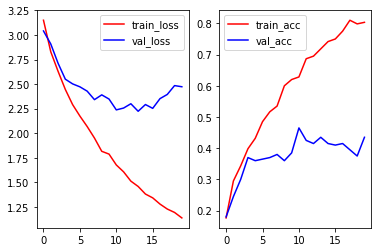

In [49]:
fig,ax = plt.subplots(ncols=2)

ax[0].plot(history.history['loss'],label='train_loss',color='r')
ax[0].plot(history.history['val_loss'],label='val_loss',color='b')
ax[0].legend()
ax[1].plot(history.history['acc'],label='train_acc',color='r')
ax[1].plot(history.history['val_acc'],label='val_acc',color='b')
ax[1].legend()
plt.show()